# Fitting a GP gyrochronology model to a data set.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load various data files.

In [5]:
data = pd.read_csv("../data/calibration_data.csv")
m = np.isfinite(data.teff.values) & np.isfinite(data.period.values) & np.isfinite(data.age_gyr.values)
m &= data.teff.values > 3500
data = data.iloc[m]

mearth = pd.read_csv("../data/mearth_kinematic_ages.csv")
mteffs = pd.read_csv("../data/mearth_teffs.csv")
mdf = pd.merge(mearth, mteffs, on="prot", suffixes=["", "_"])
mask = (mdf.teff.values < 4000) & (mdf.prot.values > 30) & (mdf.kin_age.values > 5) & (mdf.teff.values > 2800)
mask &= np.isfinite(mdf.teff.values) & np.isfinite(mdf.kin_age.values) & np.isfinite(mdf.prot.values)
mdf = mdf.iloc[mask][::1]

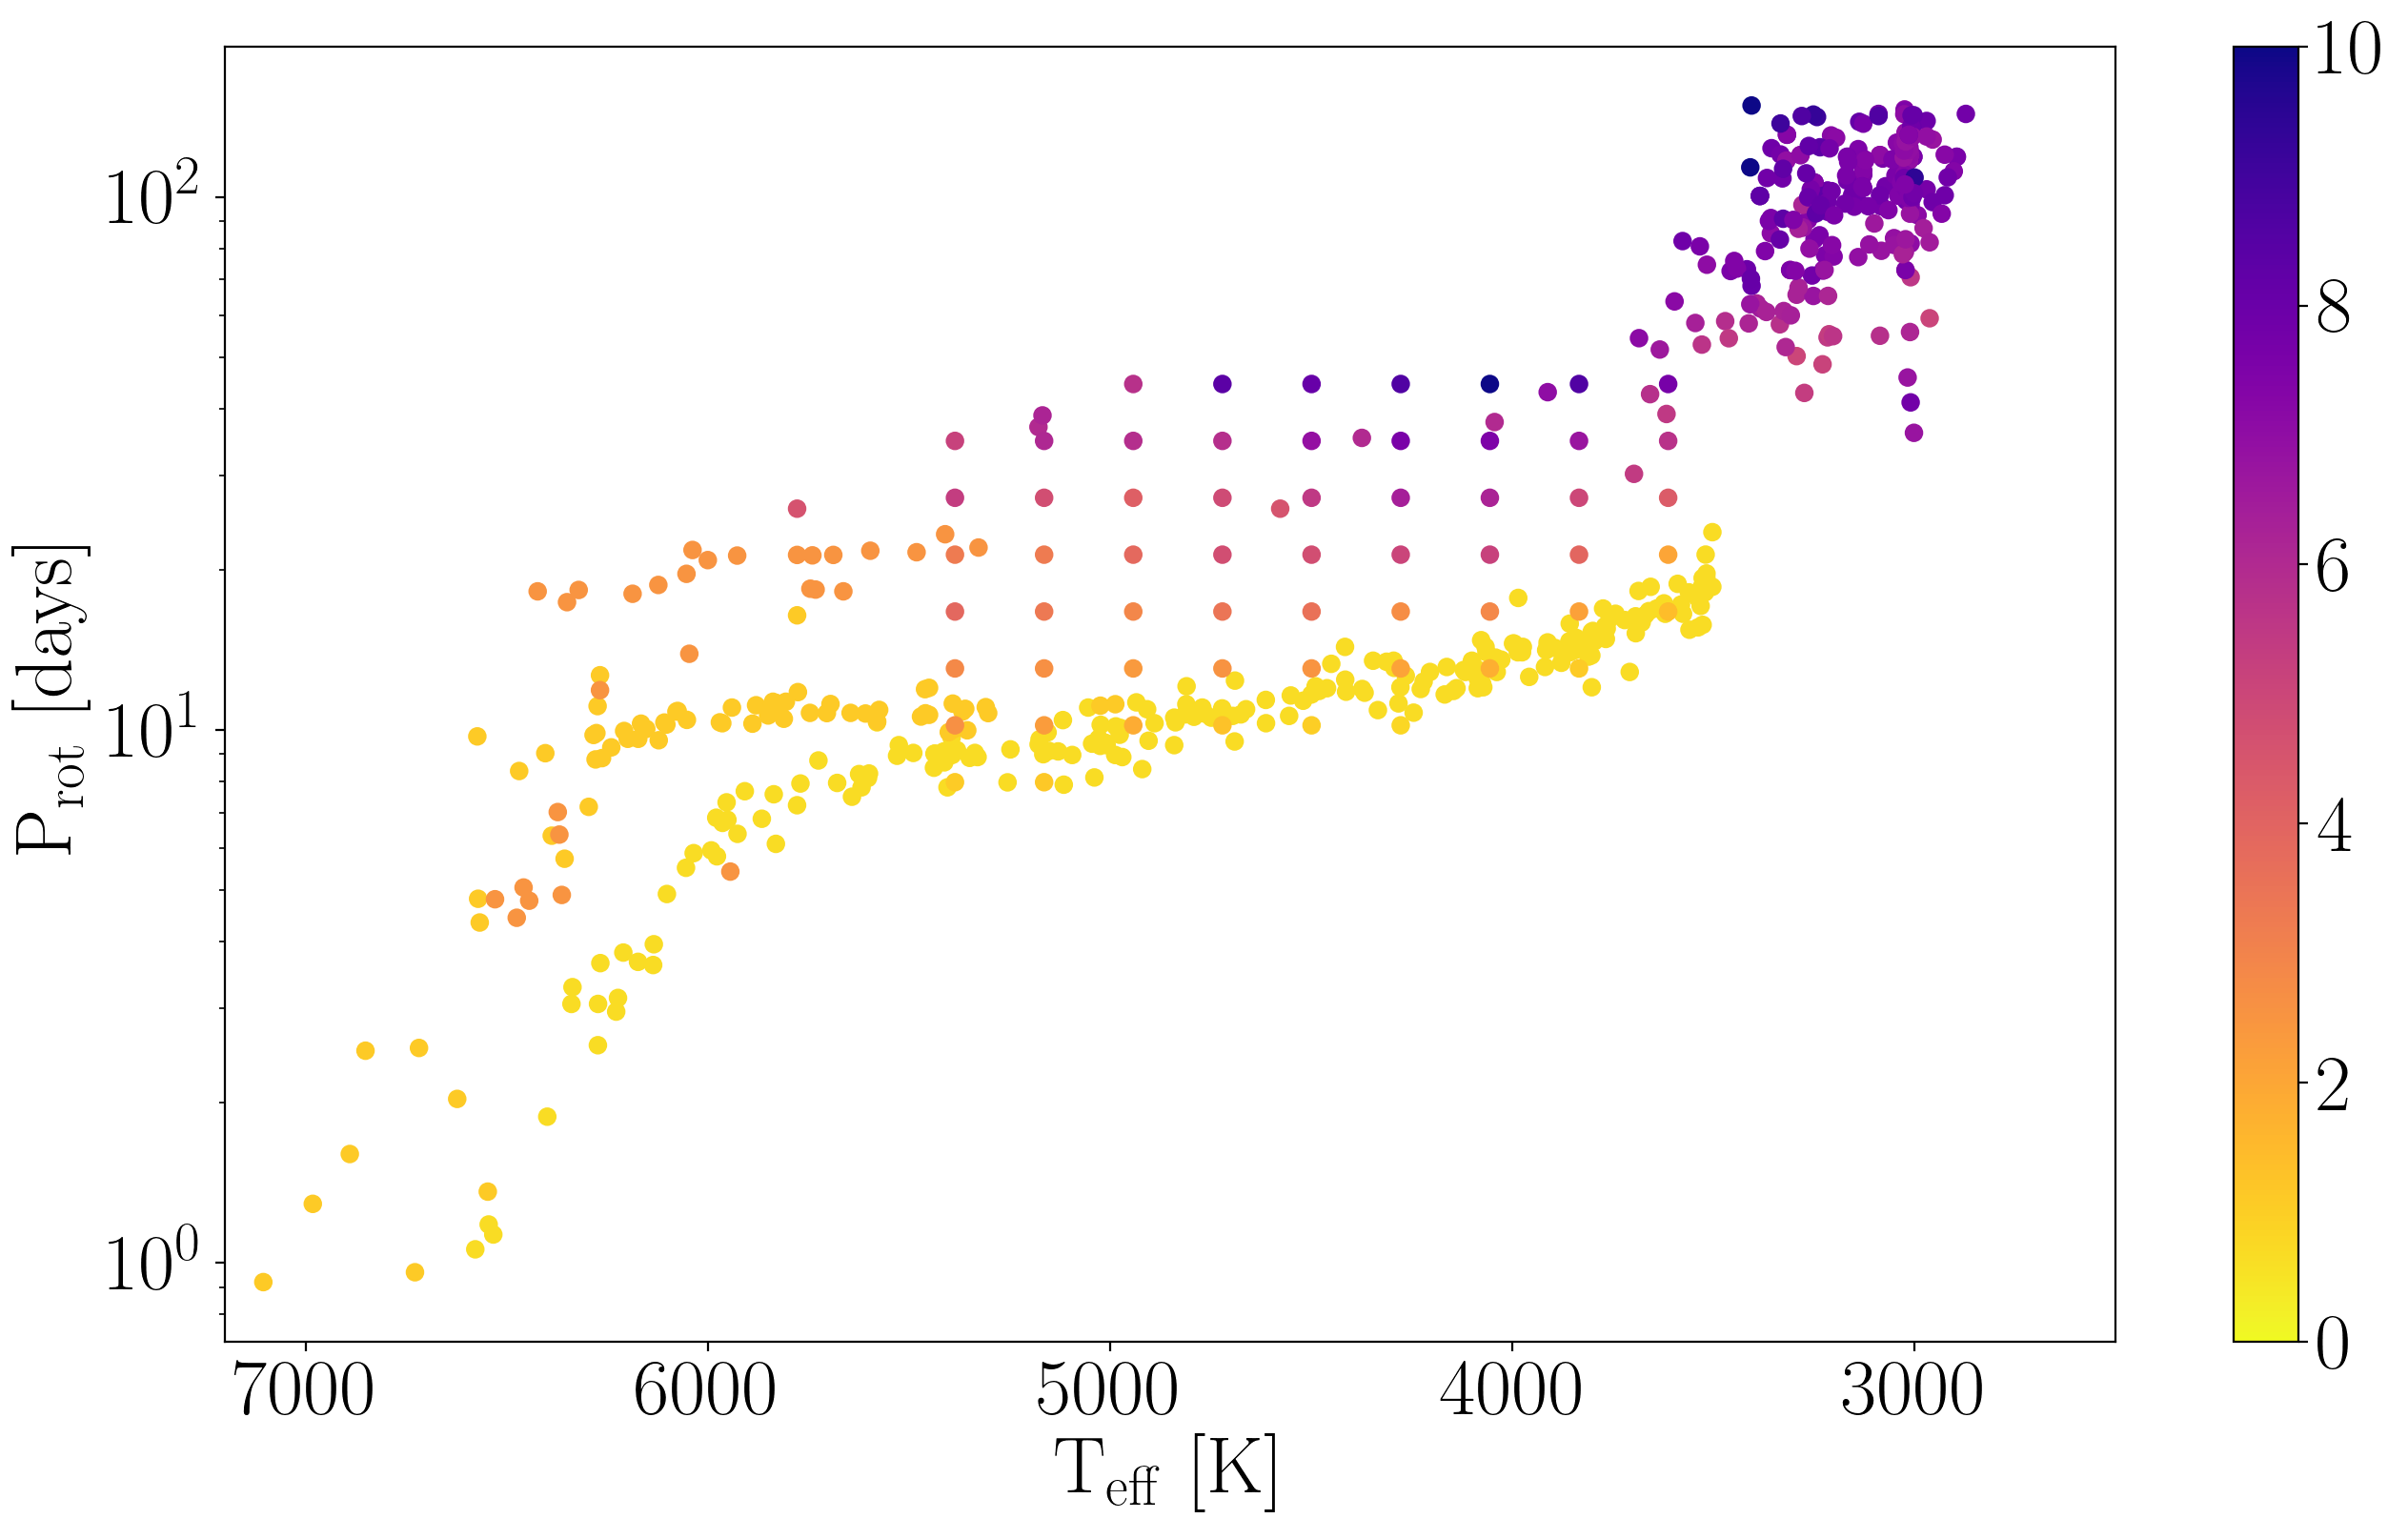

In [6]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(data.teff, data.period, c=data.age_gyr, vmin=0, vmax=10, cmap="plasma_r")
plt.scatter(mdf.teff, mdf.prot, c=mdf.kin_age, vmin=0, vmax=10, cmap="plasma_r")
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
plt.xlim(7200, 2500)
plt.yscale("log")
plt.colorbar();

Sort and format data.

In [7]:
# without mearth
# inds = np.argsort(data.teff.values)
# x1 = np.array(data.teff.values[inds])
# x2 = np.log(np.array(data.age_gyr.values[inds]))
# y = np.log(np.array(data.period.values[inds]))

# with mearth
teff = np.concatenate((data.teff.values, mdf.teff.values))
age = np.concatenate((data.age_gyr.values, mdf.kin_age.values))
prot = np.concatenate((data.period.values, mdf.prot.values))
inds = np.argsort(teff)
x1 = np.array(teff[inds])
x2 = np.log(np.array(age[inds]))
y = np.log(np.array(prot[inds]))

mu1 = np.mean(x1)
sd1 = np.std(x1)
mu2 = np.mean(x2)
sd2 = np.std(x2)
# x1_norm = (x1 - mu1) / sd1
# x2_norm = (x2 - mu2) / sd2

x2_min = np.min(x2)

xp1 = np.linspace(x1.min() - 500, x1.max() + 100, 1000)
xp2 = np.linspace(x2.min(), x2.max(), 1000)
xg1 = np.linspace(x1.min(), x1.max(), 5)
# xg2 = np.linspace(x2.min(), x2.max(), 7)
xg2 = np.linspace(x2.min(), x2.max(), 10)  # More age lines

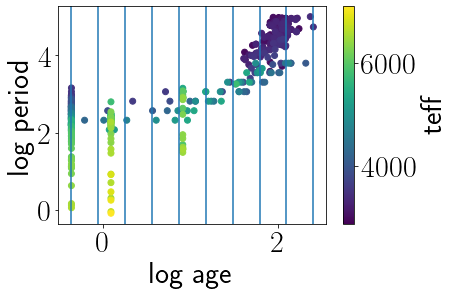

In [8]:
plt.scatter(x2, y, c=x1)
for i, x2_ref in enumerate(xg2):
    plt.axvline(x2_ref)
plt.xlabel("log age")
plt.ylabel("log period")
plt.colorbar(label="teff")

In [9]:
with pm.Model() as model:
    
    # A parameter for the position of the break in teff
    teff_break = pm.Normal("teff_break", mu=6000, sigma=500)
    
    # 3 coefficients parameters for a polynomial relation between period and sigv 
    log_period_break_c = pm.Normal("log_period_break_c", mu=0.0, sd=5)
    log_period_break_m = pm.Normal("log_period_break_m", mu=0.0, sd=5)
    log_period_break_b = pm.Normal("log_period_break_b", mu=np.log(10), sd=5)
    
    # A parameter for the smoothness?
    log_smooth = pm.Normal("log_smooth", mu=np.log(0.01), sigma=10.0)
    smooth = tt.exp(log_smooth)
    
    # Function for calculating period from sigv
    def get_log_period_break(x2):
        return log_period_break_c * (x2 - x2_min)**2 + log_period_break_m * (x2 - x2_min) + log_period_break_b
    
    # Upper and lower limits for the slope?
    slope_low = pm.Normal("slope_low", mu=0.0, sd=10.0)
    slope_high = pm.Normal("slope_high", mu=0.0, sd=10.0)
    
    # Jitter parameter
    log_s2 = pm.Normal("log_s2", mu=1.0, sd=10.0)
    
    # Mean model
    def get_mean_model(x1, x2):
        delta = x1 - teff_break  # distance between teff and teff_break
        brk = get_log_period_break(x2)  # Calculate period break from sigv
        slope = slope_low / (1 + tt.exp(smooth * delta)) + slope_high / (1 + tt.exp(-smooth * delta))
        return slope * delta + brk
    
    mean_model = get_mean_model(x1, x2)
    pm.Deterministic("mean_model", mean_model)
    
    # Parameters of the GP
    log_amp = pm.Normal("log_amp", mu=np.log(np.var(y)), sigma=10.0)
    log_ell = pm.Normal("log_ell1", mu=0.0, sigma=10.0, shape=2)
    
    # Define the kernel
    def get_K(x1, x2, xp1=None, xp2=None):
        X = np.vstack(((x1 - mu1) / sd1, (x2 - mu2) / sd2))
        
        if xp1 is None:
            dX = (X[:, :, None] - X[:, None, :]) * tt.exp(-log_ell)[:, None, None]
            r2 = tt.sum(dX ** 2, axis=0)
        else:
            Xp = tt.stack(((xp1 - mu1) / sd1, (xp2 - mu2) / sd2))
            dX = (Xp[:, :, None] - X[:, None, :]) * tt.exp(-log_ell)[:, None, None]
            r2 = tt.sum(dX ** 2, axis=0)
            
        K = tt.exp(log_amp - 0.5 * r2)
        return K
    
    K = get_K(x1, x2)
    K = tt.inc_subtensor(K[np.diag_indices(len(y))], tt.exp(log_s2) + np.zeros_like(y))
    
    alpha = tt.slinalg.solve(K, y - mean_model)
    for i, x2_ref in enumerate(xg2):  # over the grid of ages/velocities
        pred_model = get_mean_model(xp1, x2_ref)  # Evaluate the mean model over teffs at that age to get prot as a function of teff.
        Kp = get_K(x1, x2, xp1, x2_ref + np.zeros_like(xp1))
        pred = tt.dot(Kp, alpha) + pred_model  # Calculate prediction Fit GP to the residuals and add mean model back on.
        pm.Deterministic("pred_{0}".format(i), pred)  # add a parameter for each age which is the prediction at that age.
    
    # Likelihood
    pm.MvNormal("obs", mu=mean_model, cov=K, observed=y)
    
    x1_test = pm.Flat("x1_test", shape=(1,))
    x2_test = pm.Flat("x2_test", shape=(1,))
    K_test = get_K(x1, x2, x1_test, x2_test)
    y_test = pm.Deterministic("y_test", tt.dot(K_test, alpha) + get_mean_model(x1_test, x2_test))
        
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [slope_low, slope_high])
    map_soln = xo.optimize(map_soln, [log_smooth])
    map_soln = xo.optimize(map_soln, [teff_break, log_period_break_m, log_period_break_b, log_period_break_c])
    map_soln = xo.optimize(map_soln, [slope_low, slope_high, log_smooth])
    map_soln = xo.optimize(map_soln, [log_s2, log_amp, log_ell])
    map_soln = xo.optimize(map_soln)

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -922.6300164511075 -> -918.1417423153632
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -918.1417423153632 -> -918.1003284373834
optimizing logp for variables: [log_period_break_c, log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -918.1003284373834 -> -917.0280029581196
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -917.0280029581196 -> -916.9976419325768
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: -916.9976419325768 -> 69.14755899259016
optimizing logp for variables: [x2_test, x1_test, log_ell1, log_amp, log_s2, slope_high, slope_low, log_smooth, log_period_break_b, log_period_break_m, log_period_break_c, teff_break]


/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tu

message: Desired error not necessarily achieved due to precision loss.
logp: 69.14755899259016 -> 74.35797845542832


In [14]:
import pickle
with open("gp_model.pkl", "wb") as f:
    pickle.dump([model, map_soln], f)

In [12]:
mcq = pd.read_csv("../../data/Table_1_Periodic.txt")

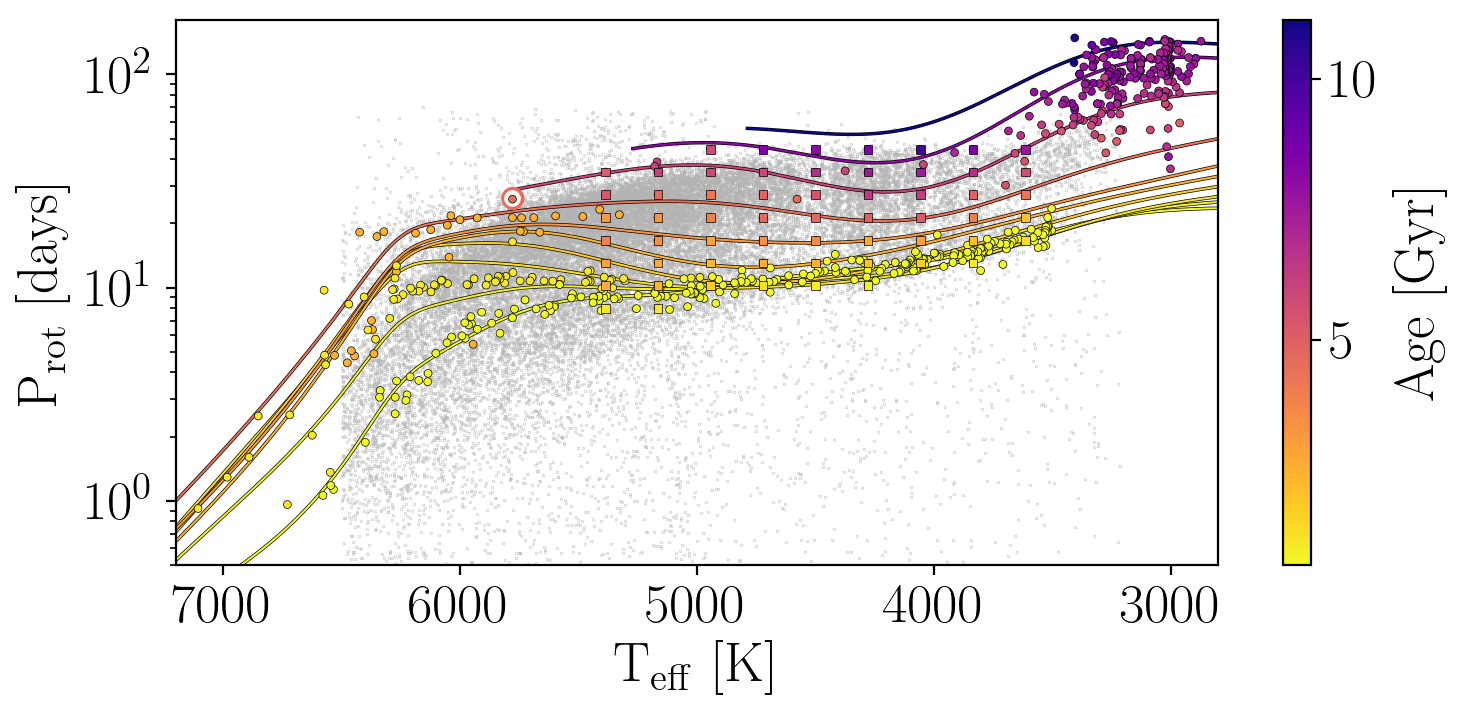

In [13]:
import matplotlib
cmap = matplotlib.cm.get_cmap("plasma_r")


plotpar = {'axes.labelsize': 20,
           'font.size': 20,
           'legend.fontsize': 15,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'text.usetex': True}
plt.rcParams.update(plotpar)

vmin = np.exp(x2).min()
vmax = np.exp(x2).max()

def get_color(x2):
    return cmap((np.exp(x2) - vmin) / (vmax - vmin))

plt.figure(figsize=(8, 4), dpi=200)

plt.plot(mcq.Teff, mcq.Prot, ".", color=".7", zorder=0, ms=.3, rasterized=True)

c = -500
for i in range(len(xg2)-1, len(xg2)):
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color="k", lw=1.25)
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color=get_color(xg2[i]), lw=0.75)
    
c = -400
for i in range(len(xg2)-2, len(xg2)-1):
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color="k", lw=1.25)
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color=get_color(xg2[i]), lw=0.75)
    
c = -300
for i in range(len(xg2)-3, len(xg2)-2):
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color="k", lw=1.25)
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color=get_color(xg2[i]), lw=0.75)

for i in range(0, len(xg2)-3):
    plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color="k", lw=1.25)
    plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color=get_color(xg2[i]), lw=0.75)

plt.scatter(x1, np.exp(y), c=np.exp(x2), cmap=cmap, vmin=vmin, vmax=vmax, s=8, edgecolor="k",
            linewidth=0.25, zorder=100)
plt.scatter(data.teff.values[-60:-1], data.period.values[-60:-1], c=data.age_gyr.values[-60:-1], cmap=cmap,
            vmin=vmin, vmax=vmax, s=10, marker="s", edgecolor="k", linewidth=0.25, zorder=101)
plt.scatter([data.teff.values[-1]-1.5], [data.period.values[-1]+.2], c=[data.age_gyr.values[-1]], cmap=cmap,
            vmin=vmin, vmax=vmax, s=70, edgecolor="",
            linewidth=0.25, zorder=98)
plt.plot([data.teff.values[-1]+1], [data.period.values[-1]+.2], "wo", ms=5, zorder=99)
    
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
# plt.xlim(7200, 3400)
plt.xlim(7200, 2800)
# plt.ylim(0.5, 80)
plt.ylim(0.5, 180)
plt.yscale("log")
plt.colorbar(label="$\mathrm{Age~[Gyr]}$");

plt.tight_layout()